# Reproducing Linear Constrained NN

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
###############################################################################
#    Linearly Constrained Neural Networks
#
#    This program is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    any later version.
#
#    This program is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU General Public License for more details.
#
#    Please see  see <https://www.gnu.org/licenses/> for a copy of the license
###############################################################################

# This code is supplementary material for the submission paper submitted to
# IEEE TRANSACTIONS ON NEURAL NETWORKS AND LEARNING SYSTEMS, a preprint version of
# this paper can be found at https://arxiv.org/abs/2002.01600
# This code will produce the results shown in Figure 5 based off the example given in
# Section 5.1 "Simulated Divergence-Free"


import torch
from matplotlib import pyplot as plt
from torch.utils import data
import numpy as np
import torch.nn as nn
import torch.autograd as ag

description = "Train 2D constrained and unconstrained model"

epochs = 400
n_data = 200


def vector_field(x, y, a=0.01):
    v1 = torch.exp(-a*x*y)*(a*x*torch.sin(x*y) - x*torch.cos(x*y))
    v2 = torch.exp(-a*x*y)*(y*torch.cos(x*y) - a*y*torch.sin(x*y))
    return (v1, v2)

def vector_field_np(x, y, a=0.001):
    v1 = np.exp(-a*x*y)*(a*x*np.sin(x*y) - x*np.cos(x*y))
    v2 = np.exp(-a*x*y)*(y*np.cos(x*y) - a*y*np.sin(x*y))
    return (v1, v2)

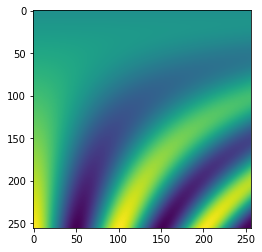

In [70]:
ngrid = 256
coords = np.linspace(0, 4, ngrid, endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2

v1, v2 = vector_field_np(coords[:,:,0], coords[:,:,1])

plt.imshow(v1)
plt.imshow(v2)

In [17]:
## ------------------ set up models-------------------------- ##
# set network size
n_in = 2
n_h1 = 100
n_h2 = 50
n_o = 1

# two outputs for the unconstrained network
n_o_uc = 2

# define model class
class DivFree2D(torch.nn.Module):
    def __init__(self, base_net):
        super(DivFree2D, self).__init__()
        self.base_net = base_net

    def forward(self, x):
        x.requires_grad = True
        y = self.base_net(x)
        dydx = ag.grad(outputs=y, inputs=x, create_graph=True, grad_outputs=torch.ones(y.size()),
                       retain_graph=True, only_inputs=True)[0]
        return y, dydx[:,1].unsqueeze(1), -dydx[:,0].unsqueeze(1)


model = DivFree2D(nn.Sequential(nn.Linear(n_in,n_h1),nn.Tanh(),nn.Linear(n_h1,n_h2),
                                         nn.Tanh(),nn.Linear(n_h2,n_o)))


model_uc = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o_uc),
)


# pregenerate validation data
x_val = 4.0 * torch.rand(2000, 2)
x1_val = x_val[:, 0].unsqueeze(1)
x2_val = x_val[:, 1].unsqueeze(1)

(v1, v2) = vector_field(x1_val, x2_val)
y1_val = v1 + 0.1 * torch.randn(x1_val.size())
y2_val = v2 + 0.1 * torch.randn(x1_val.size())
y_val = torch.cat((y1_val, y2_val), 1)


n_pred = 250
# Get the true function values on a grid
xv, yv = torch.meshgrid([torch.arange(0.0, n_pred) * 4.0 / n_pred, torch.arange(0.0, n_pred) * 4.0 / n_pred])
(v1, v2) = vector_field(xv, yv)

xv2, yv2 = torch.meshgrid([torch.arange(0.0, 20) * 4.0 / 20, torch.arange(0.0, 20) * 4.0 / 20])
(v1_2, v2_2) = vector_field(xv2, yv2)

# generate training data
x_train = torch.empty(n_data, 2)
x_train[0:int(n_data/4), 0] = 1.0 * torch.rand(int(n_data/4))
x_train[0:int(n_data/4), 1] = 4.0 * torch.rand(int(n_data/4))

x_train[int(n_data/4):2*int(n_data/4), 0] = 3+1.0 * torch.rand(int(n_data/4))
x_train[int(n_data/4):2*int(n_data/4), 1] = 4.0 * torch.rand(int(n_data/4))

x_train[2*int(n_data/4):3*int(n_data/4), 1] = 1.0 * torch.rand(int(n_data/4))
x_train[2*int(n_data/4):3*int(n_data/4), 0] = 4.0 * torch.rand(int(n_data/4))

x_train[3*int(n_data/4):4*int(n_data/4), 1] = 3+1.0 * torch.rand(int(n_data/4))
x_train[3*int(n_data/4):4*int(n_data/4), 0] = 4.0 * torch.rand(int(n_data/4))

x1_train = x_train[:, 0].unsqueeze(1)
x2_train = x_train[:, 1].unsqueeze(1)

(v1_t, v2_t) = vector_field(x1_train, x2_train)
y1_train = v1_t + 0.1 * torch.randn(x1_train.size())
y2_train = v2_t + 0.1 * torch.randn(x1_train.size())

# define Dataset class
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, x1, x2, y1, y2):
        'Initialization'
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x1)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x1 = self.x1[index]
        x2 = self.x2[index]
        y1 = self.y1[index]
        y2 = self.y2[index]

        return x1, x2, y1, y2


training_set = Dataset(x1_train, x2_train, y1_train, y2_train)

# data loader Parameters
DL_params = {'batch_size': 100,
             'shuffle': True,
             'num_workers': 2,
             'pin_memory': False}
training_generator = data.DataLoader(training_set, **DL_params)

torch.Size([200, 1])


In [18]:
# ---------------  Set up and train the constrained model -------------------------------
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # these should also be setable parameters
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10,
                                                     min_lr=1e-10,
                                                     factor=0.5,
                                                    cooldown=15)

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        (yhat, v1hat, v2hat) = model(x_train)
        loss = (criterion(y1_train, v1hat) + criterion(y2_train, v2hat)) / 2  # divide by 2 as it is a mean
        loss.backward()
        optimizer.step()
        total_loss += loss
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    (yhat, v1hat, v2hat) = model(x_val)
    loss = (criterion(y1_val, v1hat) + criterion(y2_val, v2hat)) / 2
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])

print('Training Constrained NN')

for epoch in range(epochs):
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    print('Constrained NN: epoch: ', epoch, 'training loss ', train_loss[epoch], 'validation loss', val_loss[epoch])


# work out the rms error for this one
x_pred = torch.cat((xv.reshape(n_pred * n_pred, 1), yv.reshape(n_pred * n_pred, 1)), 1)
(f_pred, v1_pred, v2_pred) = model(x_pred)
error_new = torch.cat((v1.reshape(n_pred*n_pred, 1) - v1_pred.detach(), v2.reshape(n_pred*n_pred, 1) - v2_pred.detach()), 0)
rms_error = torch.sqrt(sum(error_new * error_new) / (2*n_pred*n_pred))

Training Constrained NN
Constrained NN: epoch:  0 training loss  [2.54893112] validation loss [2.3406601]
Constrained NN: epoch:  1 training loss  [2.46873903] validation loss [2.28733492]
Constrained NN: epoch:  2 training loss  [2.45792246] validation loss [2.27211809]
Constrained NN: epoch:  3 training loss  [2.42335868] validation loss [2.28123331]
Constrained NN: epoch:  4 training loss  [2.40477586] validation loss [2.25881982]
Constrained NN: epoch:  5 training loss  [2.34965062] validation loss [2.23004794]
Constrained NN: epoch:  6 training loss  [2.29545093] validation loss [2.19849348]
Constrained NN: epoch:  7 training loss  [2.22214413] validation loss [2.17184687]
Constrained NN: epoch:  8 training loss  [2.13172555] validation loss [2.10696363]
Constrained NN: epoch:  9 training loss  [2.01634169] validation loss [2.02642012]
Constrained NN: epoch:  10 training loss  [1.87477732] validation loss [1.96990132]
Constrained NN: epoch:  11 training loss  [1.73969054] validati

Constrained NN: epoch:  98 training loss  [0.50466847] validation loss [0.76227403]
Constrained NN: epoch:  99 training loss  [0.49412671] validation loss [0.83955985]
Constrained NN: epoch:  100 training loss  [0.46538359] validation loss [0.72358179]
Constrained NN: epoch:  101 training loss  [0.45057359] validation loss [0.83602345]
Constrained NN: epoch:  102 training loss  [0.43487316] validation loss [0.76640344]
Constrained NN: epoch:  103 training loss  [0.41112477] validation loss [0.74909401]
Constrained NN: epoch:  104 training loss  [0.41046405] validation loss [0.7638604]
Constrained NN: epoch:  105 training loss  [0.40004975] validation loss [0.74963325]
Constrained NN: epoch:  106 training loss  [0.39982253] validation loss [0.72860438]
Constrained NN: epoch:  107 training loss  [0.39220244] validation loss [0.73958081]
Constrained NN: epoch:  108 training loss  [0.40091184] validation loss [0.70109165]
Constrained NN: epoch:  109 training loss  [0.40160936] validation l

Constrained NN: epoch:  195 training loss  [0.19141775] validation loss [0.54840785]
Constrained NN: epoch:  196 training loss  [0.42029047] validation loss [0.29662699]
Constrained NN: epoch:  197 training loss  [0.15445134] validation loss [0.51313084]
Constrained NN: epoch:  198 training loss  [0.28982651] validation loss [0.32161397]
Constrained NN: epoch:  199 training loss  [0.14776374] validation loss [0.34312189]
Constrained NN: epoch:  200 training loss  [0.21481527] validation loss [0.27391762]
Constrained NN: epoch:  201 training loss  [0.11285535] validation loss [0.24203184]
Constrained NN: epoch:  202 training loss  [0.15545025] validation loss [0.25334835]
Constrained NN: epoch:  203 training loss  [0.11884713] validation loss [0.22444889]
Constrained NN: epoch:  204 training loss  [0.1168974] validation loss [0.21385711]
Constrained NN: epoch:  205 training loss  [0.09564735] validation loss [0.19933149]
Constrained NN: epoch:  206 training loss  [0.09493411] validation

Constrained NN: epoch:  292 training loss  [0.03521218] validation loss [0.11729996]
Constrained NN: epoch:  293 training loss  [0.03514021] validation loss [0.11869103]
Constrained NN: epoch:  294 training loss  [0.03513913] validation loss [0.1182078]
Constrained NN: epoch:  295 training loss  [0.03583902] validation loss [0.11694688]
Constrained NN: epoch:  296 training loss  [0.03469972] validation loss [0.11820736]
Constrained NN: epoch:  297 training loss  [0.03562951] validation loss [0.11677556]
Constrained NN: epoch:  298 training loss  [0.03520483] validation loss [0.11662872]
Constrained NN: epoch:  299 training loss  [0.03667824] validation loss [0.115968]
Constrained NN: epoch:  300 training loss  [0.03533114] validation loss [0.1190656]
Constrained NN: epoch:  301 training loss  [0.03881714] validation loss [0.11627933]
Constrained NN: epoch:  302 training loss  [0.03512833] validation loss [0.11486866]
Constrained NN: epoch:  303 training loss  [0.03508707] validation lo

Constrained NN: epoch:  389 training loss  [0.03235537] validation loss [0.10369544]
Constrained NN: epoch:  390 training loss  [0.03246105] validation loss [0.1030561]
Constrained NN: epoch:  391 training loss  [0.03292124] validation loss [0.103231]
Constrained NN: epoch:  392 training loss  [0.03245503] validation loss [0.10382915]
Constrained NN: epoch:  393 training loss  [0.03263652] validation loss [0.10403447]
Constrained NN: epoch:  394 training loss  [0.03225799] validation loss [0.10301936]
Constrained NN: epoch:  395 training loss  [0.0326065] validation loss [0.10205393]
Constrained NN: epoch:  396 training loss  [0.03249139] validation loss [0.10235976]
Constrained NN: epoch:  397 training loss  [0.03224802] validation loss [0.10322282]
Constrained NN: epoch:  398 training loss  [0.03220685] validation loss [0.10333303]
Constrained NN: epoch:  399 training loss  [0.03243352] validation loss [0.10318516]


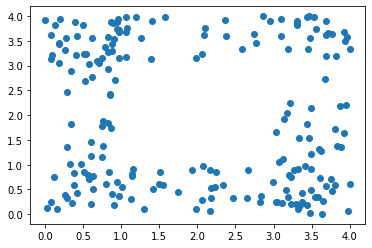

In [48]:
plt.scatter(x1_train.detach().cpu(), 
            x2_train.detach().cpu())
plt.show()
# plt.quiver(x_pred[::4,0].detach().cpu(), 
#            x_pred[::4,1].detach().cpu(), 
#            v1_pred[::4,].detach().cpu(), 
#            v2_pred[::4,].detach().cpu(), scale=1,
#            scale_units='inches', color='r')
# plt.show()

In [7]:
# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer_uc = torch.optim.Adam(model_uc.parameters(), lr=0.01)
scheduler_uc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_uc, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)
def train_uc(epoch):
    model_uc.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer_uc.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        vhat = model_uc(x_train)
        y_train = torch.cat((y1_train, y2_train), 1)
        loss = criterion(y_train, vhat)
        loss.backward()
        optimizer_uc.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval_uc(epoch):
    model_uc.eval()
    with torch.no_grad():
        (vhat) = model_uc(x_val)
        loss = criterion(y_val, vhat)
    return loss.cpu()


train_loss_uc = np.empty([epochs, 1])
val_loss_uc = np.empty([epochs, 1])

print('Training standard NN')

for epoch in range(epochs):
    train_loss_uc[epoch] = train_uc(epoch).detach().numpy()
    v_loss = eval_uc(epoch)
    scheduler_uc.step(v_loss)
    val_loss_uc[epoch] = v_loss.detach().numpy()
    print('Standard NN: epoch: ', epoch, 'training loss ', train_loss_uc[epoch], 'validation loss', val_loss_uc[epoch])

# work out final rms error for unconstrainted net
# work out the rms error for this trial
(v_pred_uc) = model_uc(x_pred)
v1_pred_uc = v_pred_uc[:, 0]
v2_pred_uc = v_pred_uc[:, 1]

error_uc = torch.cat((v1.reshape(n_pred*n_pred) - v1_pred_uc.detach(), v2.reshape(n_pred*n_pred) - v2_pred_uc.detach()), 0)
rms_uc = torch.sqrt(sum(error_uc * error_uc) / (2*n_pred*n_pred))

Training standard NN
Standard NN: epoch:  0 training loss  [3.03479314] validation loss [2.76042295]
Standard NN: epoch:  1 training loss  [2.68485475] validation loss [2.47823]
Standard NN: epoch:  2 training loss  [2.62566423] validation loss [2.41804552]
Standard NN: epoch:  3 training loss  [2.52406669] validation loss [2.44059968]
Standard NN: epoch:  4 training loss  [2.54090691] validation loss [2.58255148]
Standard NN: epoch:  5 training loss  [2.52793264] validation loss [2.50657105]
Standard NN: epoch:  6 training loss  [2.46094704] validation loss [2.40497899]
Standard NN: epoch:  7 training loss  [2.43759108] validation loss [2.3559432]
Standard NN: epoch:  8 training loss  [2.42385435] validation loss [2.32808685]
Standard NN: epoch:  9 training loss  [2.41265583] validation loss [2.31982565]
Standard NN: epoch:  10 training loss  [2.3955617] validation loss [2.32687902]
Standard NN: epoch:  11 training loss  [2.37331033] validation loss [2.34363365]
Standard NN: epoch:  1

Standard NN: epoch:  102 training loss  [1.32748818] validation loss [1.43709469]
Standard NN: epoch:  103 training loss  [1.32101667] validation loss [1.41046286]
Standard NN: epoch:  104 training loss  [1.31646132] validation loss [1.41701019]
Standard NN: epoch:  105 training loss  [1.31550515] validation loss [1.43031502]
Standard NN: epoch:  106 training loss  [1.3179884] validation loss [1.42001295]
Standard NN: epoch:  107 training loss  [1.31214762] validation loss [1.38999999]
Standard NN: epoch:  108 training loss  [1.3144294] validation loss [1.37903297]
Standard NN: epoch:  109 training loss  [1.30796337] validation loss [1.41070163]
Standard NN: epoch:  110 training loss  [1.31720829] validation loss [1.43108737]
Standard NN: epoch:  111 training loss  [1.31985927] validation loss [1.37750673]
Standard NN: epoch:  112 training loss  [1.31347442] validation loss [1.37789476]
Standard NN: epoch:  113 training loss  [1.30716801] validation loss [1.37915933]
Standard NN: epoch

Standard NN: epoch:  203 training loss  [1.12278068] validation loss [1.08255637]
Standard NN: epoch:  204 training loss  [1.10052609] validation loss [1.16305506]
Standard NN: epoch:  205 training loss  [1.10196424] validation loss [1.10078943]
Standard NN: epoch:  206 training loss  [1.10323298] validation loss [1.06583953]
Standard NN: epoch:  207 training loss  [1.10323119] validation loss [1.13613284]
Standard NN: epoch:  208 training loss  [1.08744526] validation loss [1.06278622]
Standard NN: epoch:  209 training loss  [1.08410621] validation loss [1.08833468]
Standard NN: epoch:  210 training loss  [1.09020519] validation loss [1.12250102]
Standard NN: epoch:  211 training loss  [1.07567263] validation loss [1.02522552]
Standard NN: epoch:  212 training loss  [1.07752192] validation loss [1.06897068]
Standard NN: epoch:  213 training loss  [1.06071186] validation loss [1.12262571]
Standard NN: epoch:  214 training loss  [1.06349218] validation loss [1.0004437]
Standard NN: epoc

Standard NN: epoch:  304 training loss  [0.4597429] validation loss [0.48326692]
Standard NN: epoch:  305 training loss  [0.46349305] validation loss [0.51787806]
Standard NN: epoch:  306 training loss  [0.45776987] validation loss [0.50469452]
Standard NN: epoch:  307 training loss  [0.45769507] validation loss [0.47347409]
Standard NN: epoch:  308 training loss  [0.45745915] validation loss [0.51112193]
Standard NN: epoch:  309 training loss  [0.45391449] validation loss [0.49278608]
Standard NN: epoch:  310 training loss  [0.4565438] validation loss [0.50933665]
Standard NN: epoch:  311 training loss  [0.45675975] validation loss [0.48287365]
Standard NN: epoch:  312 training loss  [0.4575915] validation loss [0.54622334]
Standard NN: epoch:  313 training loss  [0.46371362] validation loss [0.47327656]
Standard NN: epoch:  314 training loss  [0.45465767] validation loss [0.49655533]
Standard NN: epoch:  315 training loss  [0.45123845] validation loss [0.50955498]
Standard NN: epoch:

<ipython-input-8-62f3c8254b34>:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2[1].pcolor(xv, yv, Cviol, vmin=-Cviol_uc.max(), vmax=Cviol_uc.max())
<ipython-input-8-62f3c8254b34>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2[2].pcolor(xv, yv, Cviol_uc, vmin=-Cviol_uc.max(), vmax=Cviol_uc.max())


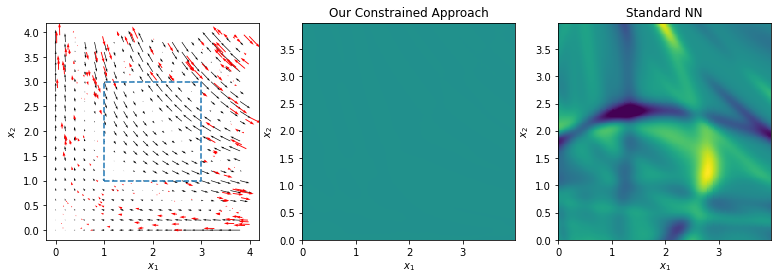

In [8]:
# ----------------- save configuration options and results -------------------------------

## determine constraint violations
with torch.no_grad():
    v1_pred_mat = v1_pred.reshape(n_pred,n_pred)
    v2_pred_mat = v2_pred.reshape(n_pred,n_pred)


    dx = 4.0/n_pred
    dy = 4.0/n_pred
    dfdy = torch.empty(n_pred,n_pred)
    dfdy[:,0] = (v2_pred_mat[:,1] - v2_pred_mat[:,0])/dy
    dfdy[:,-1] = (v2_pred_mat[:,-1] - v2_pred_mat[:,-2])/dy
    dfdy[:,1:-1] = (v2_pred_mat[:,1:-1] - v2_pred_mat[:,0:-2])/dy/2 + (v2_pred_mat[:,2:] - v2_pred_mat[:,1:-1])/dy/2

    dfdx = torch.empty(n_pred,n_pred)
    dfdx[0,:] = (v1_pred_mat[1,:] - v1_pred_mat[0,:])/dx
    dfdx[-1,:] = (v1_pred_mat[-1,:] - v1_pred_mat[-2,:])/dx
    dfdx[1:-1,:] = (v1_pred_mat[1:-1,:] - v1_pred_mat[0:-2,:])/dx/2 + (v1_pred_mat[2:,:] - v1_pred_mat[1:-1, :])/dx/2

    Cviol = dfdx + dfdy

    v1_pred_mat = v1_pred_uc.reshape(n_pred,n_pred)
    v2_pred_mat = v2_pred_uc.reshape(n_pred,n_pred)
    dfdy = torch.empty(n_pred,n_pred)
    dfdy[:,0] = (v2_pred_mat[:,1] - v2_pred_mat[:,0])/dy
    dfdy[:,-1] = (v2_pred_mat[:,-1] - v2_pred_mat[:,-2])/dy
    dfdy[:,1:-1] = (v2_pred_mat[:,1:-1] - v2_pred_mat[:,0:-2])/dy/2 + (v2_pred_mat[:,2:] - v2_pred_mat[:,1:-1])/dy/2

    dfdx = torch.empty(n_pred,n_pred)
    dfdx[0,:] = (v1_pred_mat[1,:] - v1_pred_mat[0,:])/dx
    dfdx[-1,:] = (v1_pred_mat[-1,:] - v1_pred_mat[-2,:])/dx
    dfdx[1:-1,:] = (v1_pred_mat[1:-1,:] - v1_pred_mat[0:-2,:])/dx/2 + (v1_pred_mat[2:,:] - v1_pred_mat[1:-1, :])/dx/2

    Cviol_uc = dfdx + dfdy


with torch.no_grad():
    # Initialize second plot
    f2, ax2 = plt.subplots(1, 3, figsize=(13, 4))
    Q = ax2[0].quiver(xv2, yv2, v1_2, v2_2, scale=None, scale_units='inches')
    Q._init()
    assert isinstance(Q.scale, float)
    ax2[0].quiver(x1_train, x2_train, y1_train, y2_train, scale=Q.scale, scale_units='inches', color='r')
    ax2[0].plot([1.0, 3.0, 3.0, 1.0, 1.0], [1.0, 1.0, 3.0, 3.0, 1.0],'--')
    ax2[0].set_xlabel('$x_1$')
    ax2[0].set_ylabel('$x_2$')

    ax2[1].pcolor(xv, yv, Cviol, vmin=-Cviol_uc.max(), vmax=Cviol_uc.max())
    ax2[1].set_xlabel('$x_1$')
    ax2[1].set_ylabel('$x_2$')
    ax2[1].set_title('Our Constrained Approach')


    ax2[2].pcolor(xv, yv, Cviol_uc, vmin=-Cviol_uc.max(), vmax=Cviol_uc.max())
    ax2[2].set_xlabel('$x_1$')
    ax2[2].set_ylabel('$x_2$')
    ax2[2].set_title('Standard NN')
    plt.show()

